# Importing Required Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler, Normalizer

from arch import arch_model

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import json
import warnings
import os
import ast

sns.set()
warnings.filterwarnings("ignore")

# Importing Dataset

In [3]:
config_url = '../../hourlyAPI/config/coins/coins_to_track.json'
f = open(config_url)
tracked_coins = ast.literal_eval(json.load(f)['coins'])
f.close()
print(tracked_coins)

['DCR', 'CTSI', 'BTC', 'FTM', 'TRB', 'MANA', 'BAT', 'GXS', 'STORM', 'OMG', 'STMX', 'WAN', 'IOST', 'NMR', 'FET', 'ICX', 'MATIC', 'SKL', 'VET', 'KEEP', 'ALGO', 'DOGE', 'AXS', 'TRX', 'BNT', 'SAND', 'RUNE', 'HBAR', 'WAVES', 'FUN', 'ARPA', 'CREAM', 'ETH', 'DOCK', 'NEXO', 'SRM', 'LTO', 'ETC', 'BTS', 'DOT', 'VTH', 'EOS', 'ONT', 'AGLD', 'NKN', 'CRV', 'CELR', 'CRO', 'OCEAN', 'CAKE', 'MDX', 'CELO', 'SXP', 'RVN', 'QTUM', 'ZEC', 'AUDIO', 'ACH', 'AVAX', 'SUSHI', 'ANT', 'UMA', 'FIL', 'BAND', 'BEAM', 'ATOM', 'UNI', 'TOMO', 'ERD', 'ENJ', 'PERL', 'YFI', 'CHZ', 'FTT', 'SC', 'WBTC', 'API3', 'ZIL', 'BCH', 'CHR', 'AAVE', 'DENT', 'MKR', 'HT', 'REN', 'COTI', 'CEL', 'PNT', 'HIVE', '1INCH', 'HOT', 'AMP', 'LTC', 'ADA', 'SNX', 'IOTX', 'MITH', 'TFUEL', 'XMR', 'ARDR', 'RLY', 'PERP', 'LUNA', 'REQ', 'ZRX', 'NEO', 'MFT', 'WRX', 'HC', 'REEF', 'STORJ', 'NULS', 'BAL', 'STPT', 'SHIB', 'NANO', 'DASH', 'RLC', 'DATA', 'KSM', 'THETA', 'LINK', 'MTL', 'SOL', 'DGB', 'GRT', 'AION', 'XLM', 'COMP', 'DUSK', 'MTA', 'BNB', 'OGN', 'XT

In [4]:
def load_coin_dataset(coin):
    url = '../../data/coins_tracked/' + coin
    years = ['2019', '2020', '2021', '2022']
    df = pd.DataFrame()
    start_train = "2019-07-01 01:00:00"

    if os.path.exists(url):
        for y in years:
            path = url + '/'+ y +'.csv'
            if os.path.exists(path):
                df_year = pd.read_csv(path)
                df_year.Time = pd.to_datetime(df_year.Time)
                df_year.set_index("Time", inplace = True)
                df_year[coin] = df_year.Price
                df_year.drop(['Price', 'BidVolume', 'AskVolume'], axis=1, inplace = True)
                df = pd.concat([df, df_year])
                
            else:
                print('For coin ', coin, ' year ', y, ' is not present')
    else:
        print('Data not available for ', coin)
    
    df.sort_index(inplace=True)
    df = df[start_train: df.index[-1]]

    return df

In [5]:
df = pd.DataFrame()
for coin in tracked_coins:
    df_coin = load_coin_dataset(coin)
    df = df.join(df_coin, how="outer")

For coin  CTSI  year  2019  is not present
For coin  CTSI  year  2020  is not present
For coin  TRB  year  2019  is not present
For coin  NMR  year  2019  is not present
For coin  MATIC  year  2019  is not present
For coin  SKL  year  2019  is not present
For coin  SKL  year  2020  is not present
For coin  KEEP  year  2019  is not present
For coin  AXS  year  2019  is not present
For coin  AXS  year  2020  is not present
For coin  SAND  year  2019  is not present
For coin  RUNE  year  2019  is not present
For coin  CREAM  year  2019  is not present
For coin  SRM  year  2019  is not present
For coin  DOT  year  2019  is not present
For coin  VTH  year  2019  is not present
For coin  AGLD  year  2019  is not present
For coin  AGLD  year  2020  is not present
For coin  CRV  year  2019  is not present
For coin  CAKE  year  2019  is not present
For coin  CAKE  year  2020  is not present
For coin  MDX  year  2019  is not present
For coin  MDX  year  2020  is not present
For coin  CELO  year 

In [6]:
df.tail()

,DCR,CTSI,BTC,FTM,TRB,MANA,BAT,GXS,STORM,OMG,...,OGN,XTZ,KAVA,CQT,ANKR,TROY,XRP,XEM,KNC,LRC
Time,,,,,,,,,,,,,,,,,,,,,
2022-02-14 02:00:00,65.04,0.4286,41721.14,1.829,20.55,2.734,0.7780,0.8645,0.01085,4.511,...,0.3617,3.769,3.167,0.387,0.07254,0.007057,0.7874,0.1085,1.769,0.8850
2022-02-14 03:00:00,65.21,0.4333,41934.92,1.849,20.75,2.756,0.7859,0.8689,0.01090,4.552,...,0.3627,3.800,3.196,0.387,0.07346,0.007052,0.7932,0.1081,1.787,0.8933
2022-02-14 04:00:00,65.02,0.4321,41975.21,1.853,20.77,2.766,0.7878,0.8697,0.01091,4.531,...,0.3669,3.782,3.194,0.387,0.07365,0.007083,0.7940,0.1082,1.780,0.8932
2022-02-14 05:00:00,64.44,0.4274,41792.13,1.843,20.62,2.724,0.7811,0.8659,0.01087,4.491,...,0.3586,3.759,3.181,0.388,0.07257,0.007066,0.7866,0.1083,1.765,0.8814
2022-02-14 06:00:00,64.24,0.4355,42207.03,1.873,20.98,2.778,0.7919,0.8745,0.01097,4.541,...,0.3565,3.788,3.207,0.391,0.07363,0.007096,0.7956,0.1087,1.792,0.8983


In [7]:
def Wilder(data, periods):
    start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
    Wilder = np.array([np.nan]*len(data))
    Wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
    for i in range(start+periods,len(data)):
        Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
    return(Wilder)
    
def calculate_indicators(df):
    all_data = df.copy()
    all_data['SMA_5'] = all_data['Close'].transform(lambda x: x.rolling(window = 5).mean())
    all_data['SMA_15'] = all_data['Close'].transform(lambda x: x.rolling(window = 15).mean())
    all_data['SMA_ratio'] = all_data['SMA_15'] / all_data['SMA_5']
    all_data['prev_close'] = all_data['Close'].shift(1)


    all_data['Diff'] = all_data['Close'].transform(lambda x: x.diff())
    all_data['Up'] = all_data['Diff']
    all_data.loc[(all_data['Up']<0), 'Up'] = 0

    all_data['Down'] = all_data['Diff']
    all_data.loc[(all_data['Down']>0), 'Down'] = 0 
    all_data['Down'] = abs(all_data['Down'])

    all_data['avg_5up'] = all_data['Up'].transform(lambda x: x.rolling(window=5).mean())
    all_data['avg_5down'] = all_data['Down'].transform(lambda x: x.rolling(window=5).mean())

    all_data['avg_15up'] = all_data['Up'].transform(lambda x: x.rolling(window=15).mean())
    all_data['avg_15down'] = all_data['Down'].transform(lambda x: x.rolling(window=15).mean())

    all_data['RS_5'] = all_data['avg_5up'] / all_data['avg_5down']
    all_data['RS_15'] = all_data['avg_15up'] / all_data['avg_15down']

    all_data['RSI_5'] = 100 - (100/(1+all_data['RS_5']))
    all_data['RSI_15'] = 100 - (100/(1+all_data['RS_15']))

    all_data['RSI_ratio'] = all_data['RSI_5']/all_data['RSI_15']

    all_data['5Ewm'] = all_data['Close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
    all_data['15Ewm'] = all_data['Close'].transform(lambda x: x.ewm(span=15, adjust=False).mean())
    all_data['MACD'] = all_data['15Ewm'] - all_data['5Ewm']

    all_data['15MA'] = all_data['Close'].transform(lambda x: x.rolling(window=15).mean())
    all_data['SD'] = all_data['Close'].transform(lambda x: x.rolling(window=15).std())
    all_data['upperband'] = all_data['15MA'] + 2*all_data['SD']
    all_data['lowerband'] = all_data['15MA'] - 2*all_data['SD']
    all_data['RC'] = all_data['Close'].transform(lambda x: x.pct_change(periods = 15))

    all_data.replace([np.inf, -np.inf], np.nan, inplace=True)

    all_data.dropna(inplace=True) 
    
    return all_data

In [8]:
for coin in tracked_coins:
    coin_df = pd.DataFrame()
    coin_df.index = df.index
    coin_df['Close'] = df[coin]
    coin_df = calculate_indicators(coin_df)
    coin_df = coin_df.drop(['Close'], axis=1)
    coin_df = coin_df.add_prefix(coin + '_')
    df = df.join(coin_df)

#     if k =='BTC':
#         df = pd.read_csv(k+'-USD.csv', index_col='Date', parse_dates=['Date'])
#         df = calculate_indicators(df)
#         df = df.add_suffix('_'+k)
#     else:
#         dataframe = pd.read_csv(k+'-USD.csv', index_col='Date', parse_dates=['Date'])
#         dataframe = calculate_indicators(dataframe)
#         dataframe = dataframe.add_suffix('_'+k)
#         df = df.join(dataframe)
# df = df.dropna()
df.head()

,DCR,CTSI,BTC,FTM,TRB,MANA,BAT,GXS,STORM,OMG,...,LRC_RSI_15,LRC_RSI_ratio,LRC_5Ewm,LRC_15Ewm,LRC_MACD,LRC_15MA,LRC_SD,LRC_upperband,LRC_lowerband,LRC_RC
Time,,,,,,,,,,,,,,,,,,,,,
2019-07-01 01:00:00,30.62,NaN,10898.54,0.02711,NaN,0.05071,0.3239,2.093,0.002763,2.514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01 02:00:00,31.10,NaN,10999.70,0.02751,NaN,0.04994,0.3155,2.197,0.002851,2.541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01 03:00:00,31.28,NaN,11085.91,0.02704,NaN,0.05379,0.3311,2.134,0.002935,2.575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01 04:00:00,31.25,NaN,11086.59,0.02757,NaN,0.04949,0.3305,2.125,0.002827,2.557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01 05:00:00,31.16,NaN,11013.00,0.02739,NaN,0.04945,0.3247,2.120,0.002802,2.516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.tail(10)
df.to_csv('coins_history_indicators.csv', sep='\t')
# print(coin_df)

## Correlation study

In [10]:
def plot_correlation(df):
    corr = df.corr()
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot()
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(df.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.columns)
    plt.show()

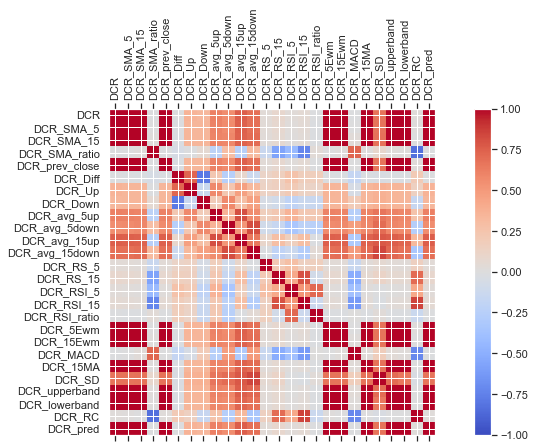

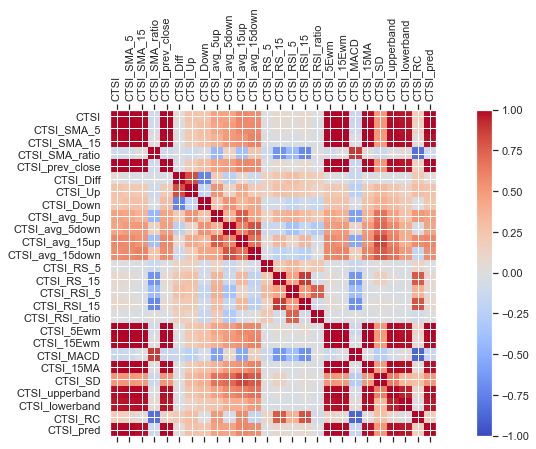

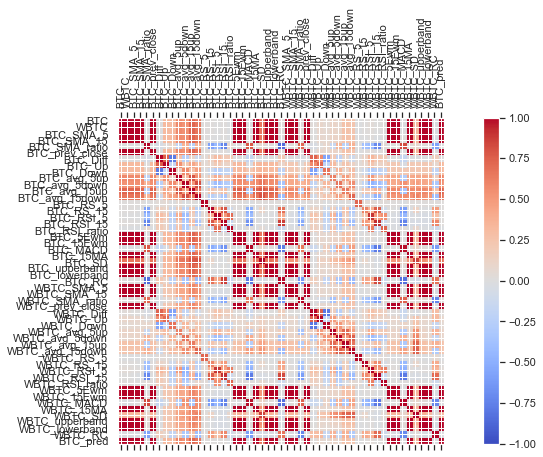

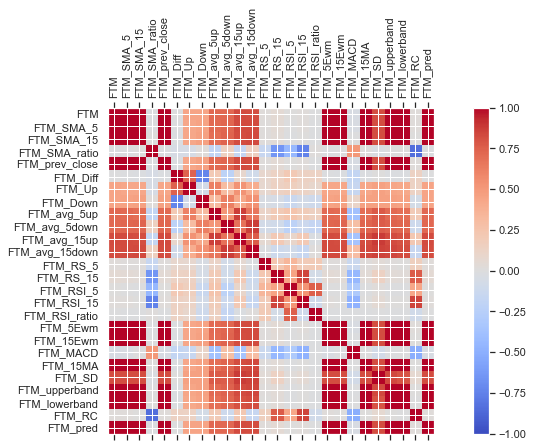

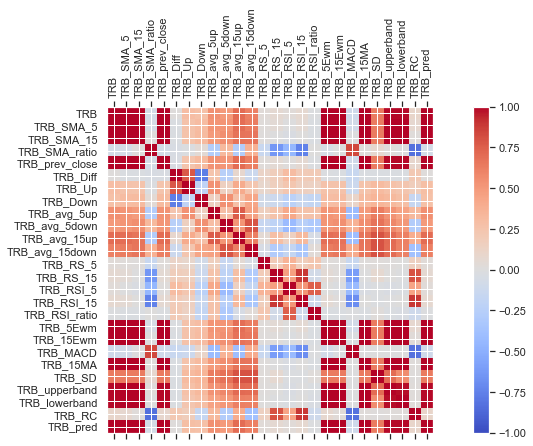

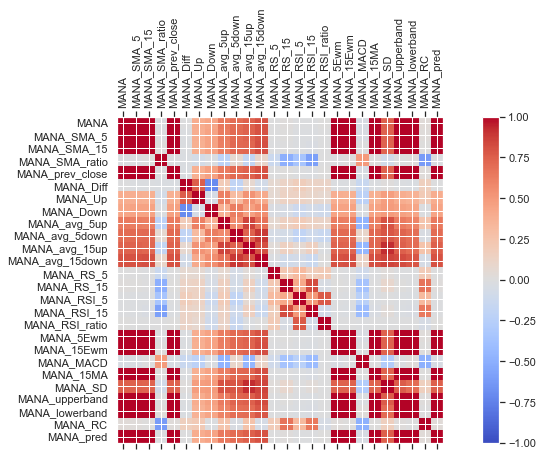

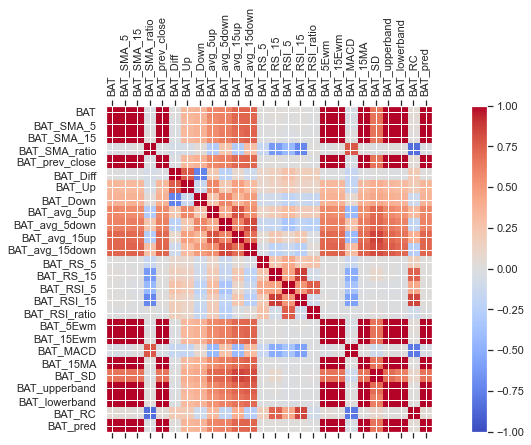

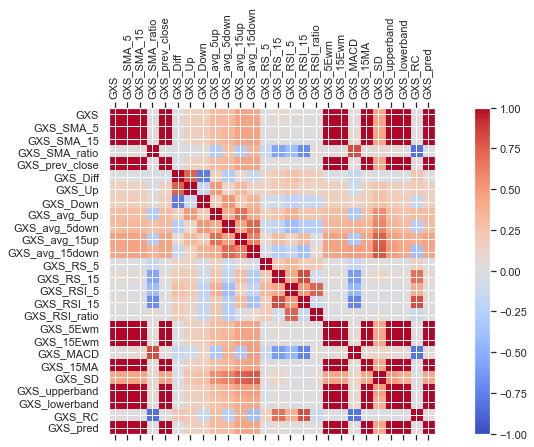

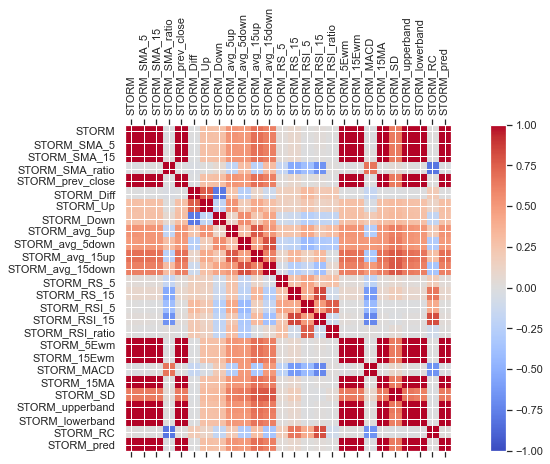

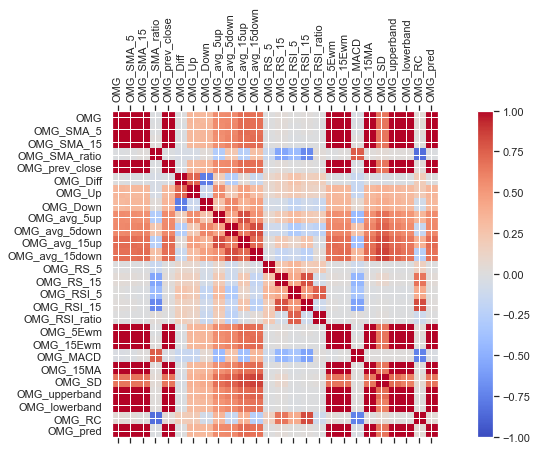

In [11]:
for coin in tracked_coins[:10]:
    df_col = df.columns
    coin_col = [x for x in df_col if coin in x]
    coin_df = df[coin_col]
    coin_df[coin + '_pred'] = coin_df[coin].shift(-1)
    plot_correlation(coin_df)

In [12]:
corr_matrix = coin_df.corr().abs()

In [13]:
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

In [14]:
# So we are selecting the columns which are having absolute correlation greater than 0.95 and making a list of those columns named 'dropping_these_features'.
dropping_these_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

In [15]:
print(dropping_these_features)

['OMG_SMA_5', 'OMG_SMA_15', 'OMG_prev_close', 'OMG_5Ewm', 'OMG_15Ewm', 'OMG_15MA', 'OMG_upperband', 'OMG_lowerband', 'OMG_pred']
